## Автоматическое построение моделей и разделение данных

AutoML-классификация: Предсказание отклика на маркетинговую кампанию

Цель этого скрипта — автоматизировать построение модели машинного обучения для задачи бинарной классификации: 
определение, откликнется ли клиент на маркетинговое предложение.

Используется AutoML-подход, который автоматически подбирает оптимальный алгоритм, гиперпараметры и, при необходимости, признаки.

Основные этапы:

1. Загрузка и базовая подготовка данных
2. Разделение на выборки, проверка корректности разбиения
3. Обучение модели с помощью AutoML
4. Оценка модели на отложенной тестовой выборке

### 1) Подключение библиотек и базовая подготовка данных

In [2]:
# Стандартная библиотека
import sys
sys.path.insert(0, '/home/alorozhkov/jup/ml_projects/Marketing_Response/utils/')
sys.path.insert(0, '/home/alorozhkov/jup/ml_projects/Marketing_Response/src/')

import os
from getpass import getpass
import gdown
import shap

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", module="matplotlib.font_manager")

import numpy as np
np.random.seed(42)


import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = lambda x: ('%.12f' % x).rstrip('0').rstrip('.')

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rcParams['font.family'] = 'DejaVu Sans'


#MLFlow
import mlflow
mlflow.set_tracking_uri(f'http://127.0.0.1:5000/')
mlflow.set_experiment("Marketing_Response")

#AutoML
from pycaret.classification import *


#Стат тесты
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Нормализация и балансировка данных
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#Подбор гиперпарамметров
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, train_test_split
)


#Обучение модели
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

#Метрики
from sklearn.metrics import (
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score, roc_auc_score,
    PrecisionRecallDisplay, RocCurveDisplay
)

# Отбор признаков
from sklearn.feature_selection import SelectKBest, f_classif

# Подключение дополнительных модулей/функция
from data_preprocessing import split_and_scale, check_distribution
from visualisation import (
    compare_all_numerical_features,
    compare_all_categorical_features
)

In [3]:
#Пути к данным
processed_data = '/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_DATA.csv'
processed_automl = '/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_EDA_DATA.csv'
# #Настройки
# pd.set_option('display.max_columns', 100)
# sns.set(style='whitegrid')

In [4]:
#Загрузка данных
df_model = pd.read_csv('/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_EDA_DATA.csv')
df_model.head(2)

,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,HigherEducation,IsHighIncome,IncomeLog,TotalSpentLog,AcceptedAnyCmp
0,58,7,1,68,0,0,1,0,10.970591974103,7.388946097618,0
1,38,5,0,71,1,0,1,0,10.74386869031,3.332204510175,0


### 2) Разделение на выборки, проверка корректности разбиения

In [5]:
# Определеяю параметры:
target_column = "Response" 
feature_columns = ['Recency', 'NumWebVisitsMonth', 'Age', 'HasChildren','MaritalFlag', 'HigherEducation', 'IsHighIncome', 'AcceptedAnyCmp', 'TotalSpentLog']
numeric_columns = ['Recency', 'NumWebVisitsMonth', 'Age', 'TotalSpentLog'] 

In [6]:
# Вызываем функцию
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale(
    df=df_model,
    target_col=target_column,
    feature_cols=feature_columns,
    num_cols=numeric_columns,
    test_size=0.3,  # 30% на val+test
    val_size=0.5,   # из них половина (15%) на test, остальное (15%) на val
    random_state=42,
    verbose=True
)

Размер выборок:
  Train: (1405, 9), y_train: (1405,)
  Val:   (301, 9), y_val:   (301,)
  Test:  (302, 9), y_test:  (302,)


Чтобы проверить корректность распредления данных визуально посмотрим, насколько похожи распределения числовых признаков между выборками train, val, test:

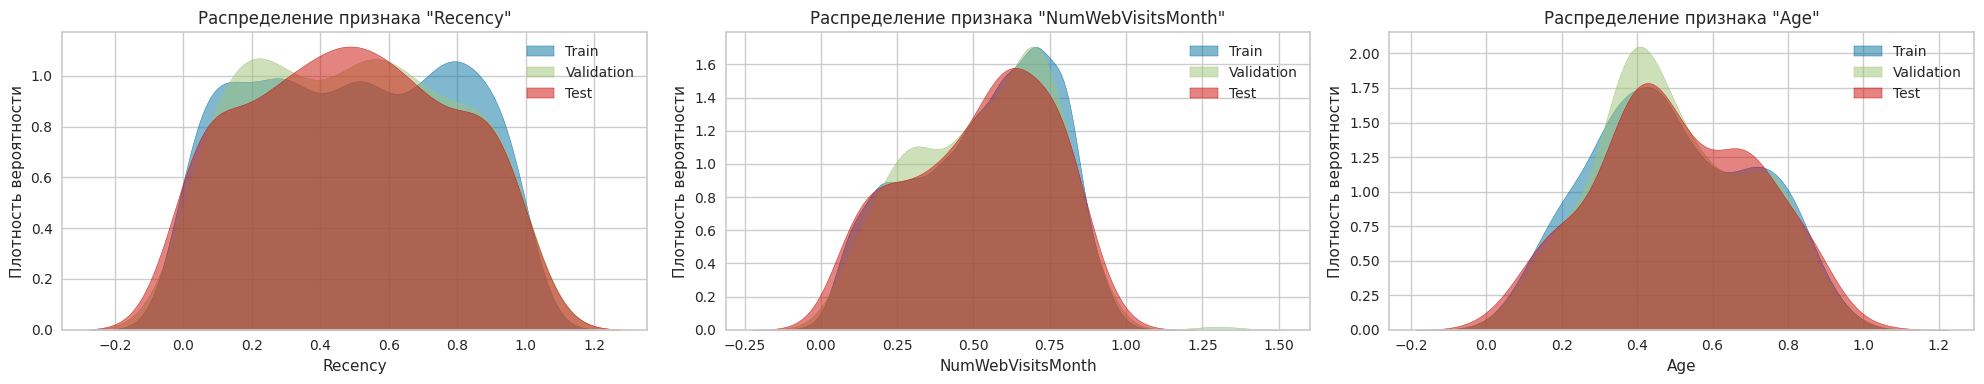

In [7]:
# Указываю числовые признаки
numerical_features = ['Recency', 'NumWebVisitsMonth', 'Age' ]

# Вызываю функцию по распределению признаков
compare_all_numerical_features(numerical_features, X_train, X_val, X_test)

Вывод по графикам:

Распределения числовых признаков в train, validation и test выборках визуально очень похожи, что свидетельствует о корректном разделении данных. 

Смотрим насколько выборки сбалансированы по категориальным признакам:

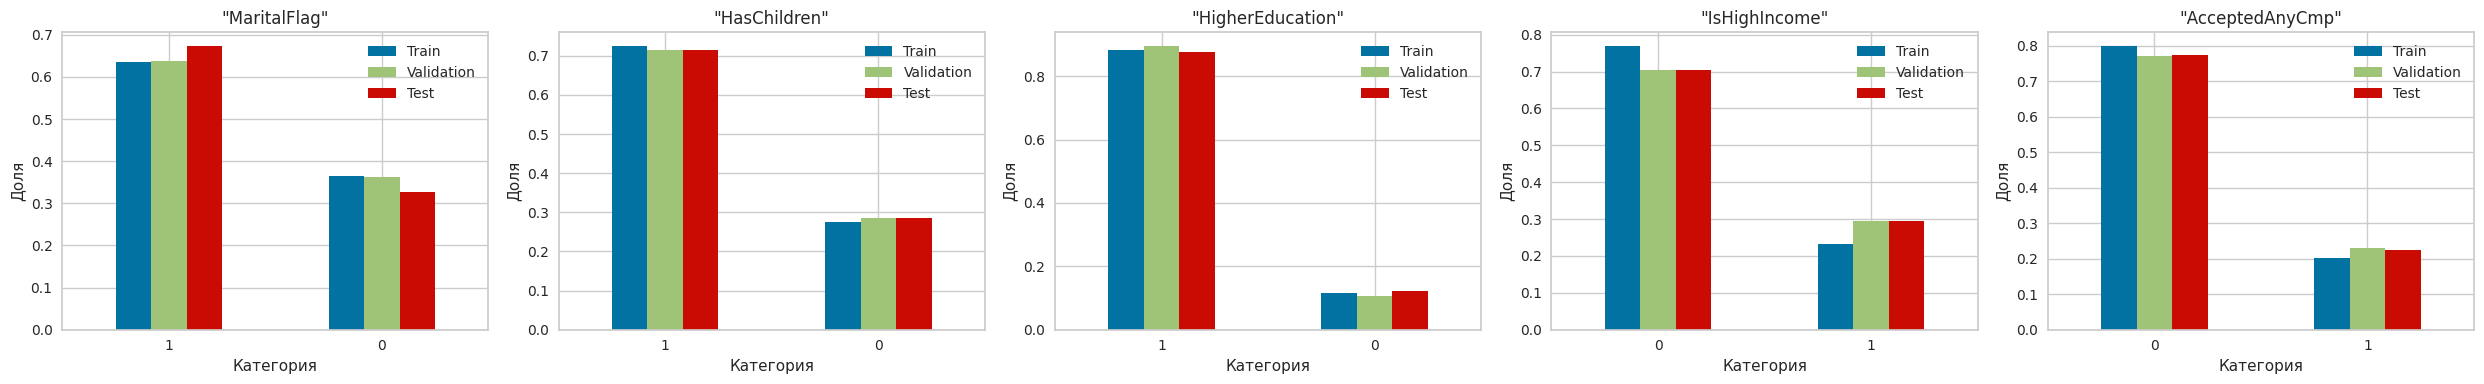

In [8]:
# Указываю категориальные признаки
categorical_features = ['MaritalFlag', 'HasChildren', 'HigherEducation', 'IsHighIncome', 'AcceptedAnyCmp']

# Вызываю функцию по распределению признаков
compare_all_categorical_features(categorical_features, X_train, X_val, X_test)

Выборки сбалансированы по категориальным признакам, но некоторые признаки требуют дополнительной обработки из-за дисбаланса классов.

При обучении буду учитывать данный момент

Проверим распределение классов по выборкам - смотрим долю каждого класса в таргете по трем выборкам:


Train class distribution:
Response
0   0.846263345196
1   0.153736654804
Name: proportion, dtype: float64


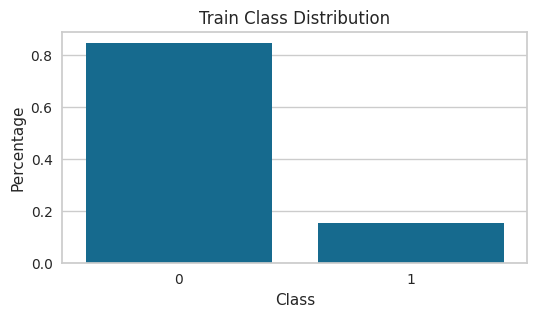


Validation class distribution:
Response
0   0.847176079734
1   0.152823920266
Name: proportion, dtype: float64


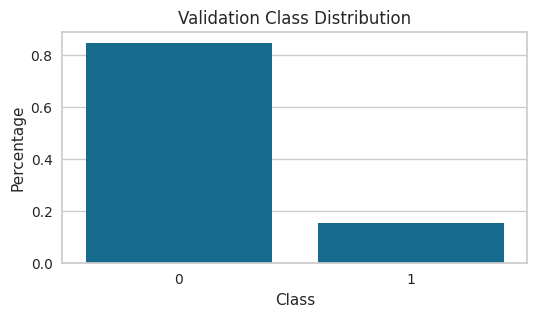


Test class distribution:
Response
0   0.847682119205
1   0.152317880795
Name: proportion, dtype: float64


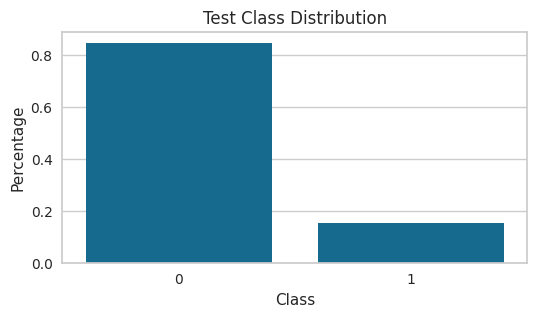

In [9]:
# Проверяем распределение
check_distribution(y_train, "Train")
check_distribution(y_val, "Validation") 
check_distribution(y_test, "Test")

Видим, что в классах дисбаланс, но распределение одитнаковое по всем выборкам -- > разбиение на выборки прошло успешно

### 3) AutoML

В этом разделе мы применим фреймворк PyCaret для автоматического построения и сравнения моделей классификации. 

Что будет сделано:

- Обьединение данных в один датасет (нужен один датасет для работы Pycaret)
- Инициализация эксперимента с помощью set()
- Сранение моделей по основным метрикам 
- Выбор лучших моделей для дальнейшей работы

В данной задаче целевая переменная (Response) является дисбалансированной: примерно 85% объектов относятся к классу 0 (не отклик), и только 15% — к классу 1 (отклик на маркетинговую кампанию)

В условиях дисбаланса использовать Accuracy как основную метрику некорректно, так как даже модель, игнорирующая класс 1, может демонстрировать высокую точность за счёт доминирующего класса.

Поскольку бизнес-цель состоит в поиске клиентов, с высокой вероятностью отреагирующих на кампанию, критически важна способность модели обнаруживать класс 1. Это делает метрику Recall (полноту) важной — она показывает, какая доля откликнувшихся клиентов была правильно найдена.

Однако ориентироваться только на Recall тоже рискованно — высокая полнота часто достигается за счёт большого количества ложных срабатываний (низкой Precision). Поэтому оптимальной метрикой в данной задаче является F1-score, которая представляет собой сбалансированное среднее между Precision и Recall.

In [10]:
# Объединяю даннные   в один DataFrame для Pycaret
train_df = X_train.copy()
train_df['Response'] = y_train

In [ ]:
#  PyCaret
clf_setup = setup(
    data=train_df,
    target='Response',
    fold=5,            # Количество фолдов для кросс-валидации
    session_id=42,     # Обеспечиваем воспроизводимость данных
    normalize=False,   # Признаки уже подготовлены, поэтомы отключаем нормализацию 
    fix_imbalance='SMOTE' # Учитываем дисбаланс классов
)

best_model = compare_models(sort='F1', turbo=True) # сравниваем модели по метрике F1

,Description,Value
0,Session id,42
1,Target,Response
2,Target type,Binary
3,Original data shape,"(1405, 10)"
4,Transformed data shape,"(2086, 10)"
5,Transformed train set shape,"(1664, 10)"
6,Transformed test set shape,"(422, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:02:07
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7812,0.8474,0.7753,0.4015,0.5237,0.4023,0.4425,0.0320
lda,Linear Discriminant Analysis,0.7792,0.8478,0.7753,0.3962,0.5200,0.3974,0.4384,0.0280
lr,Logistic Regression,0.7772,0.8474,0.7686,0.3927,0.5164,0.3926,0.4320,0.5900
ada,Ada Boost Classifier,0.8107,0.8178,0.6559,0.4279,0.5157,0.4050,0.4209,0.1240
svm,SVM - Linear Kernel,0.7670,0.8517,0.7682,0.3888,0.5055,0.3786,0.4239,0.0720
rf,Random Forest Classifier,0.8393,0.8088,0.5308,0.4770,0.5001,0.4050,0.4073,0.2660
gbc,Gradient Boosting Classifier,0.8331,0.8064,0.5308,0.4753,0.4952,0.3970,0.4015,0.2300
lightgbm,Light Gradient Boosting Machine,0.8301,0.8112,0.4910,0.4534,0.4675,0.3674,0.3701,0.3380
qda,Quadratic Discriminant Analysis,0.7528,0.8030,0.6886,0.3479,0.4599,0.3221,0.3557,0.0280
et,Extra Trees Classifier,0.8250,0.7774,0.4308,0.4363,0.4320,0.3289,0.3297,0.2000


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Выводы о качестве:

-  F1-score является оптимальной метрикой для данной задачи, так как она балансирует между Precision  и Recall.
   Топ 2 модели по данной метрики для дальнейшей работы  - Ridge Classifier(максимальный f1 и хороший AUC) и Logistic Regression(практически такие же занчения метрик как и в  Ridge Classifier)
-  По AUC SVM - Linear Kernel показала наилучший результат, однако  её F1-score ниже, чем у Ridge

Список моделей для дальнейшей работы:
- Ridge Classifier
- Logistic Regression
- SVM - Linear Kernel
- Catboost (с настройкой гиперпарамметров)